## 트랜스포머의 입력 이해하기
필요한 패키지를 임포트

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

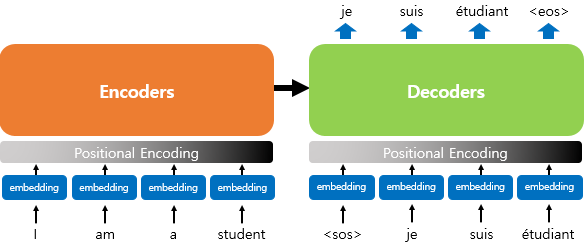
많은 자연어 처리 모델들은 텍스트 문장을 입력으로 받기 위해 단어를 임베딩 벡터로 변환하는 벡터화 과정을 거치며, 트랜스포머 또한 그 점에서는 다른 모델들과 다르지 않다.    
하지만 트랜스포머 모델의 입력 데이터 처리에는 RNN 계열의 모델들과 다른 점이 한 가지 있는데, 바로 임베딩 벡터에 어떤 값을 더해준 뒤에 입력으로 사용한다는 점이다.

트랜스포머는 RNN과 다르게 같은 단어라도 그 단어가 문장의 몇 번째 어순으로 입력되었는지를 모델에 추가로 알려 주기 위해, 단어의 임베딩 벡터에다가 위치 정보를 가진 벡터(Positional Encoding) 값을 더해서 모델의 입력으로 삼는다.

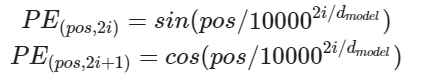

포지셔널 인코딩의 벡터값은 위의 수식에 의해서 정해진다.
- $d^{model}$ 은 임베딩 벡터의 차원을 의미
- $pos$는 입력 문장에서의 임베딩 벡터의 위치
- $i$는 임베딩 벡터 내의 차원의 인덱스

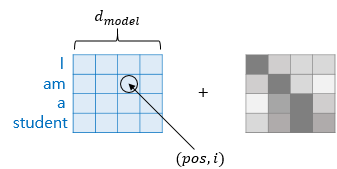

In [ ]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]


행의 크기가 50, 열의 크기가 512인 행렬을 그려보자.   
최대 문장의 길이가 50이고 워드 임베딩 차원을 512로 하는 모델의 입력 벡터 모양이 그래프와 같은 것이다.

In [ ]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

실제 논문에서는 포지셔널 인코딩을 다음과 같이 표현하였다.

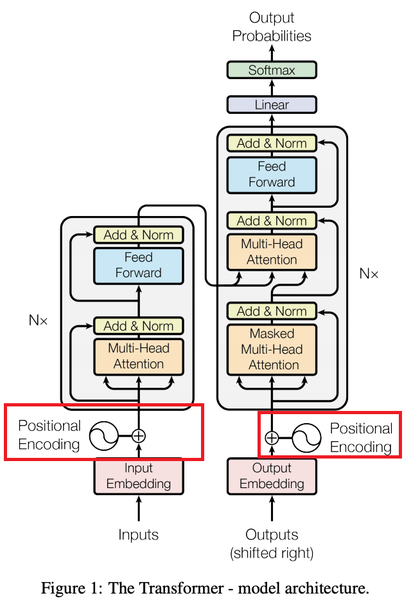

## 어텐션? 어텐션!
어텐션 메커니즘은 다음과 같다.
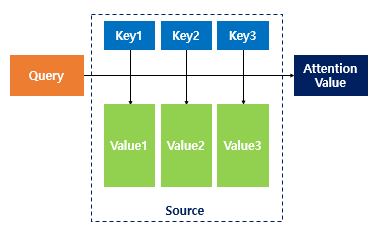

어텐션 함수는 주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구한 후, 구해낸 이 유사도를 키(Key)와 맵핑되어있는 각각의 '값(Value)'에 반영한 다음, 유사도가 반영된 '값(Value)'을 모두 더해서 뭉쳐주면 최종 결과인 __어텐션 값(Attention Value)__ 이 도출된다.

## 트랜스포머에서 사용된 어텐션
- 첫 번째. 인코더 셀프 어텐션은 인코더에서, 
- 두 번째. 디코더 셀프 어텐션은 디코더에서,
- 세 번째. 인코더-디코더 어텐션 또한 디코더에서 이루어진다.

트랜스포머의 어텐션 함수에 사용되는 쿼리(Query), 키(Key), 밸류(Value) 는 기본적으로 __'단어 (정보를 함축한) 벡터'__ 이며,
여기서 __'단어 벡터'__ 란 초기 입력으로 사용되었던 임베딩 벡터가 아니고, 트랜스포머의 여러 연산을 거친 후의 단어 벡터이다.

그럼 위 세 가지 어텐션이 하는 일을 조금 더 자세히 알아보면
- 인코더 셀프 어텐션 : 인코더의 입력으로 들어간 문장 내 단어들이 서로 유사도를 구한다.
- 디코더 셀프 어텐션 : 단어를 1개씩 생성하는 디코더가 이미 생성된 앞 단어들과의 유사도를 구한다.
- 인코더-디코더 어텐션 : 디코더가 잘 예측하기 위해서 인코더에 입력된 단어들과 유사도를 구한다.


### 셀프 어텐션(Self Attention)
셀프 어텐션이란 유사도를 구하는 대상이 다른 문장의 단어가 아니라 현재 문장 내의 단어들이 서로 유사도를 구하는 경우를 말한다.

## 스케일드 닷 프로덕트 어텐션
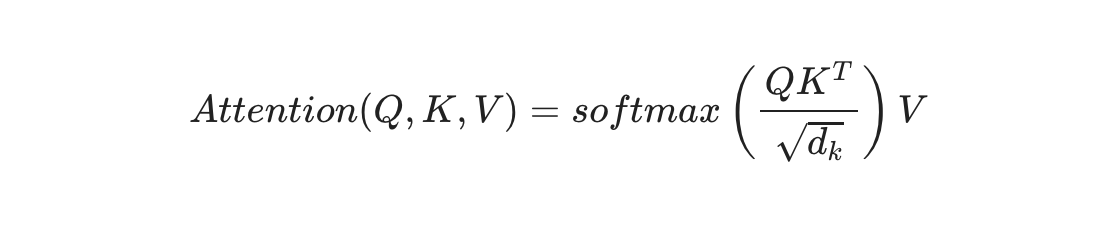
Q, K, V는 각각 쿼리(Query), 키(Key), 값(Value)를 나타낸다

어텐션 함수는 주어진 '쿼리(Query)'에 대해서 모든 '키(Key)'와의 유사도를 각각 구한 후, 구해낸 이 유사도를 키와 맵핑되어있는 각각의 '값(Value)'에 반영해 준다. 그리고 유사도가 반영된 '값(Value)'을 모두 더해서 뭉쳐주면 최종 결과인 __어텐션 값(Attention Value)__ 라고 한다.

- Q, K, V는 단어 벡터를 행으로 하는 문장 행렬이다.
- 벡터의 내적(dot product) 은 벡터의 유사도를 의미한다.
- 특정 값을 분모로 사용하는 것은 값의 크기를 조절하는 스케일링(Scaling)을 위함이다.

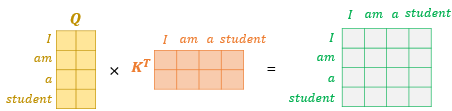

유사도 값을 스케일링 해주기 위해서 행렬 전체를 특정 값으로 나눠주고, 유사도를 0과 1사이의 값으로 Normalize해주기 위해서 소프트맥스 함수를 사용한다.

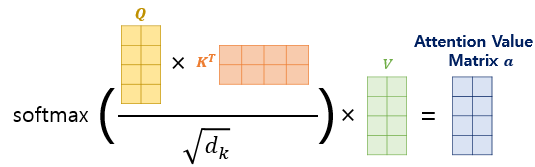

수식은 내적(dot product)을 통해 단어 벡터 간 유사도를 구한 후에, 
특정 값을 분모로 나눠주는 방식으로 Q와 K의 유사도를 구하였다고 하여 __스케일드 닷 프로덕트 어텐션(Scaled Dot Product Attention)__ 이라한다.

In [ ]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

## 머리통이 여러개인 어텐션
### 병렬로 어텐션 수행하기
트랜스포머에서 `num_heads`라는 변수는 기계가 몇 개의 똑똑한 머리를 사용할지,  
병렬적으로 몇 개의 어텐션 연산을 수행할지를 결정하는 하이퍼파라미터입니다.

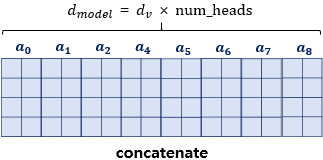

- `d_model`은 임베딩 벡터의 차원
트랜스포머의 초기 입력인 문장 행렬의 크기는 문장의 길이를 행으로, `d_model`을 열의 크기로 가진다.

트랜스포머는 이렇게 입력된 문장 행렬을 `num_heads`의 수만큼 쪼개서 어텐션을 수행하고,   
이렇게 얻은 `num_heads`의 개수만큼의 어텐션 값 행렬을 다시 하나로 concatenate한다.  
위의 그림은 `num_heads`가 8개인 경우인데, 다시 concatenate하면서 열의 크기가 `d_model`이 됩니다.



### 멀티-헤드 어텐션
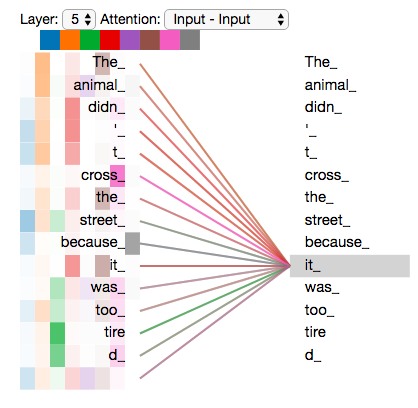
[출처 : http://jalammar.github.io/illustrated-transformer/]

`num_heads`의 값이 8일 때, 병렬로 수행되는 어텐션이 서로 다른 셀프 어텐션 결과를 얻을 수 있음을 보여준다.  
다시 말해 8개의 머리는 각각 다른 관점에서 어텐션을 수행하므로 한 번의 어텐션만 수행했다면 놓칠 수도 있던 정보를 캐치할 수 있다.  
예를 들어 위 그림에서라면 it_이라는 토큰이 animal_과 유사하다고 보는 관점과 street_과 유사하다고 보는 관점이 한꺼번에 모두 표현 가능하다는 뜻이다.

어텐션을 병렬로 수행하는 것을 __멀티 헤드 어텐션__ 이라고 부른다.




### 구현하기
__멀티 헤드 어텐션__ 을 구현하면 다음과 같고, 내부적으로는 __스케일드 닷 프로덕트 어텐션 함수__ 를 호출한다.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

## 마스킹
마스킹(Masking) 이란, 특정 값들을 가려서 실제 연산에 방해가 되지 않도록 하는 기법이다.
트랜스포머에서는 어텐션을 위해서 크게 두 가지 마스킹을 사용한다.

### 패딩 마스킹(Padding Masking)
첫 번째 마스킹은 패딩 토큰(Padding token)을 이용한 방법이다.

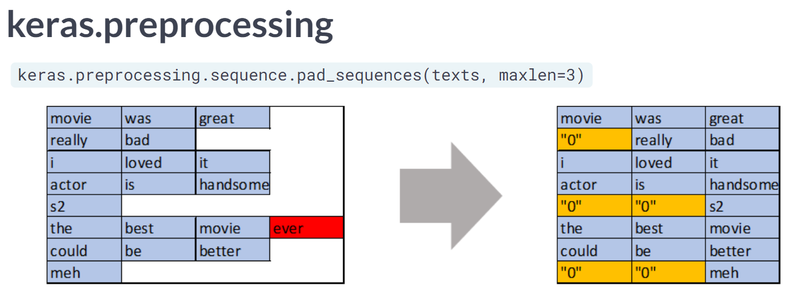

패딩은 문장의 길이가 서로 다를 때, 모든 문장의 길이를 동일하게 해주는 과정에서 정해준 길이보다 짧은 문장의 경우에는 숫자 0을 채워서 문장의 길이를 맞춰주는 자연어 처리 전처리 방법이다. 위 그림은 keras 의 `pad_sequences()`를 사용하여 패딩을 하는 과정을 시각화한 그림이다. 하지만 사실 이렇게 주어진 숫자 0은 실제 의미가 있는 단어가 아니므로 실제 어텐션 등과 같은 연산에서는 제외할 필요가 있으며, 패딩 마스킹은 이를 위해 숫자 0인 위치를 체크한다.

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

이 함수에 정수 시퀀스를 입력으로 하면, 이 함수는 숫자가 0인 부분을 체크한 벡터를 return한다.

In [ ]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

오직 숫자가 0인 위치에서만 숫자 1이 나오고, 숫자 0이 아닌 위치에서는 숫자 0인 벡터를 출력한다

### 룩 어헤드 마스킹(Look-ahead masking, 다음 단어 가리기)
RNN은 __step__ 이라는 개념이 존재해서 각 __step__ 마다 단어가 순서대로 입력으로 들어가는 구조인 반면  
트랜스포머의 경우에는 문장 행렬을 만들어 한 번에 행렬 형태로 입력으로 들어간다는 특징이 있다. 이 특징 때문에 추가적인 마스킹(Masking) 을 필요하다.



#### RNN
디코더를 구현했을 경우

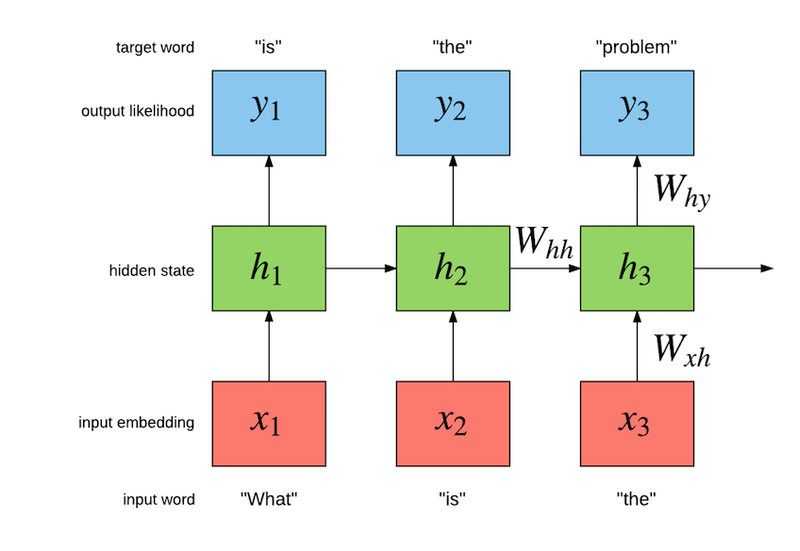
출처 : http://torch.ch/blog/2016/07/25/nce.html

RNN은 구조상으로 다음 단어를 만들어 갈 때, 자신보다 앞에 있는 단어들만 참고해서 다음 단어를 예측

#### 트랜스포머
전체 문장이 문장 행렬로 들어가기 때문에 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측할 수 있다.
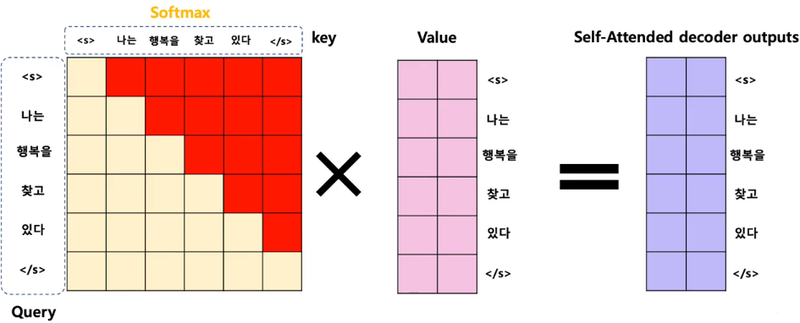
출처 : https://www.youtube.com/watch?v=xhY7m8QVKjo

빨간색으로 색칠된 부분은 마스킹을 표현.  
ex) Query 단어가 '찾고'라고 한다면, 이 '찾고'라는 행에는 `<s>`, `<나는>`, `<행복을>`, `<찾고>`까지의 열만 보이고 그 뒤 열은 아예 빨간색으로 칠해져 있다.

In [ ]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

직접 입력을 넣어 테스트

In [ ]:
print(create_look_ahead_mask(tf.constant([[1, 2, 3, 4, 5]])))

대각선의 형태로 숫자 1이 채워지는 것을 볼 수 있다.   
그런데 이 마스킹과 패딩 마스킹은 별개이므로, 이 마스킹을 수행할 때 만약에 숫자 0인 단어가 있다면 이 또한 패딩 해야 합니다.  
그래서 `create_look_ahead_mask()` 함수는 내부적으로 앞서 구현한 패딩 마스크 함수도 호출하고 있다.

In [ ]:
print(create_look_ahead_mask(tf.constant([[0, 5, 1, 5, 5]])))

## 인코더
### 인코더 층 만들기
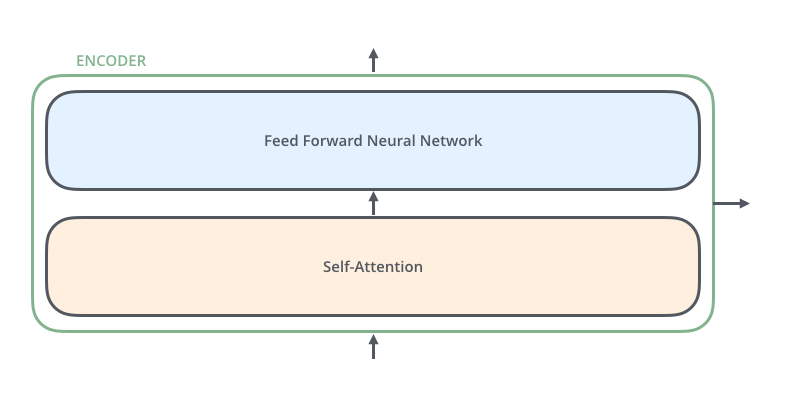
[출처 : http://jalammar.github.io/illustrated-transformer/]

하나의 인코더 층은 크게 총 2개의 서브 층(sublayer)으로 나누어진다.
- 셀프 어텐션 : 멀티 헤드 어텐션으로 병렬적으로 이루어진다.
- 피드 포워드 신경망

두 개의 서브 층을 가지는 하나의 인코더 층을 구현하는 함수는 다음과 같으며, 함수 내부적으로 첫 번째 서브 층과 두 번째 서브 층을 구현하고 있다.

In [ ]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

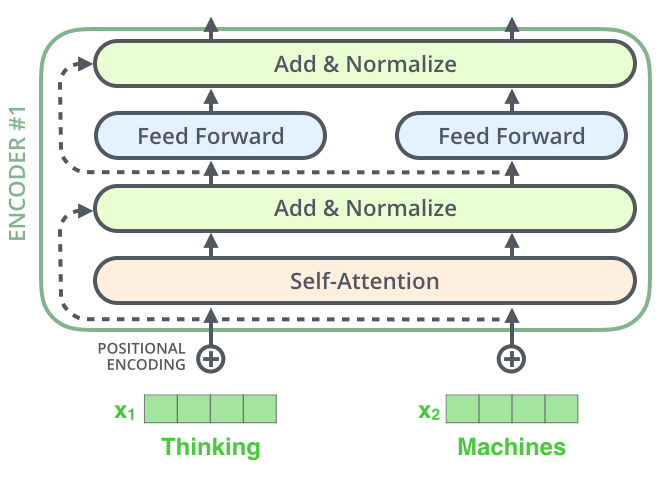

[출처 : http://jalammar.github.io/illustrated-transformer/]

### 인코더 층을 쌓아 인코더 만들기
이렇게 구현한 인코더 층을 __임베딩 층(Embedding layer)__ 과 __포지셔널 인코딩(Positional Encoding)__ 을 연결하고, 사용자가 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성된다.

인코더와 디코더 내부에서는 각 서브 층 이후에 훈련을 돕는 __Layer Normalization__ 이라는 테크닉이 사용되었습니다.  
위 그림에서는 Normalize라고 표시된 부분에 해당된다.

트랜스포머는 하이퍼파라미터인 `num_layers` 개수의 인코더 층을 쌓는다.  
논문에서는 총 6개의 인코더 층을 사용하였지만, 실습에서는 학습 시간을 고려하여 그보다 적은 개수를 사용할 예정이다.

In [ ]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

## 디코더
### 디코더 층
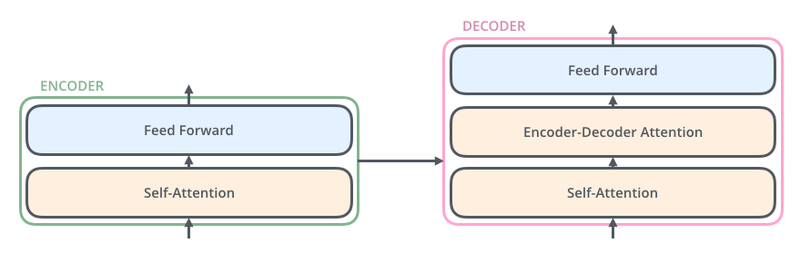
[출처 : http://jalammar.github.io/illustrated-transformer/]

- 첫 번째는 셀프 어텐션, 
- 두 번째는 인코더-디코더 어텐션, 
- 세 번째는 피드 포워드 신경망이다. 

인코더-디코더 어텐션은 셀프 어텐션과는 달리, Query가 _디코더의 벡터_ 인 반면에, Key와 Value가 _인코더의 벡터_ 라는 특징이 있다.   
이 부분이 인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정이다.

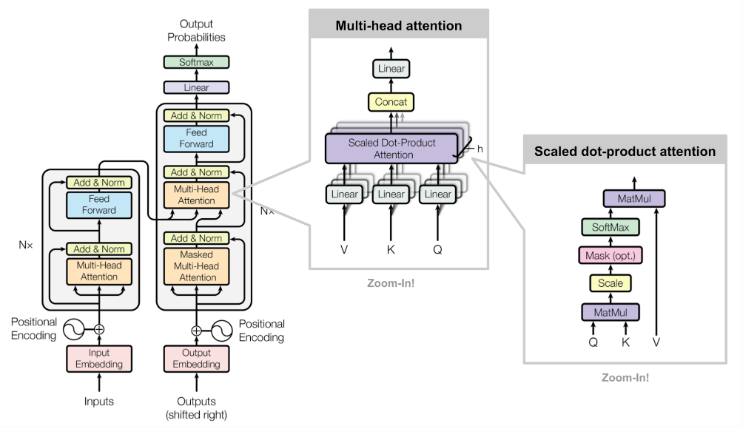
[출처 : https://medium.com/@shreyasikalra25/predict-movie-reviews-with-bert-88d8b79f5718]

인코더의 __셀프 어텐션__ 과 마찬가지로 디코더의 __셀프 어텐션__, __인코더-디코더 어텐션__ 두 개의 어텐션 모두 __스케일드 닷 프로덕트 어텐션__ 을 __멀티 헤드 어텐션__ 으로 병렬적으로 수행한다.

In [ ]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

### 디코더 층을 쌓아 디코더 만들기
이렇게 구현한 디코더의 층은 __임베딩 층(Embedding layer)__ 과 __포지셔널 인코딩(Positional Encoding)__ 을 연결하고, 
사용자가 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더가 완성된다.

인코더와 마찬가지로 `num_layers` 개수의 디코더 층을 쌓는다.   
논문에서는 총 6개의 디코더 층을 사용하였지만, 실습에서는 학습 시간을 고려하여 그보다 적은 개수를 사용할 것이다.

In [ ]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

## 챗봇의 병렬 데이터 받아오기
예제 데이터로는 __Cornell Movie-Dialogs Corpus__ 라는 영화 및 TV 프로그램에서 사용되었던 대화의 쌍으로 구성된 데이터셋을 사용한다.

[목표]
- 정해진 개수인 50,000개의 질문과 답변의 쌍을 추출
- 문장에서 단어와 구두점 사이에 공백을 추가
- 알파벳과 ! ? , . 이 4개의 구두점을 제외하고 다른 특수문자는 모두 제거


In [ ]:
path_to_zip = tf.keras.utils.get_file(
    'cornell_movie_dialogs.zip',
    origin='http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip',
    extract=True)

path_to_dataset = os.path.join(
    os.path.dirname(path_to_zip), "cornell movie-dialogs corpus")

path_to_movie_lines = os.path.join(path_to_dataset, 'movie_lines.txt')
path_to_movie_conversations = os.path.join(path_to_dataset,'movie_conversations.txt')

데이터 중에서 5만 개만 가져오도록 하고 질문과 답변의 쌍의 형태로 데이터셋을 가공한다.

In [ ]:
# 사용할 샘플의 최대 개수
MAX_SAMPLES = 50000
print(MAX_SAMPLES)

<전처리 함수>  
이번 전처리는 __정규 표현식(Regular Expression)__ 을 사용하여 __구두점(punctuation)__ 을 제거하여   
단어를 __토크나이징(tokenizing)__ 하는 일에 방해가 되지 않도록 정제하는 것을 목표

In [ ]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence

In [ ]:
# 질문과 답변의 쌍인 데이터셋을 구성하기 위한 데이터 로드 함수
def load_conversations():
  id2line = {}
  with open(path_to_movie_lines, errors='ignore') as file:
    lines = file.readlines()
  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    id2line[parts[0]] = parts[4]

  inputs, outputs = [], []
  with open(path_to_movie_conversations, 'r') as file:
    lines = file.readlines()

  for line in lines:
    parts = line.replace('\n', '').split(' +++$+++ ')
    conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]

    for i in range(len(conversation) - 1):
      # 전처리 함수를 질문에 해당되는 inputs와 답변에 해당되는 outputs에 적용.
      inputs.append(preprocess_sentence(id2line[conversation[i]]))
      outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))

      if len(inputs) >= MAX_SAMPLES:
        return inputs, outputs
  return inputs, outputs

In [ ]:
# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations()
print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

In [ ]:
print('전처리 후의 22번째 질문 샘플: {}'.format(questions[21]))
print('전처리 후의 22번째 답변 샘플: {}'.format(answers[21]))

## 병렬 데이터 전처리하기
이번 스텝에서 전체적인 과정을 요약하면 다음과 같다..

- TensorFlow Datasets __SubwordTextEncoder__ 를 토크나이저로 사용. \
단어보다 더 작은 단위인 Subword를 기준으로 토크나이징하고,  각 토큰을 고유한 __정수로 인코딩__
- 각 문장을 토큰화하고 각 문장의 시작과 끝을 나타내는 __START_TOKEN__ 및 __END_TOKEN__ 을 추가한다.
- 최대 길이 __MAX_LENGTH__인 40을 넘는 문장들은 필터링
- MAX_LENGTH보다 길이가 짧은 문장들은 40에 맞도록 __패딩__


### 단어장(Vocabulary) 만들기
각 단어에 고유한 정수 인덱스를 부여하기 위해서 단어장(Vocabulary)을 만들어보자.   
단어장을 만들 때는 질문과 답변 데이터셋을 모두 사용하여 만든다.

In [ ]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [ ]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [ ]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

두 개의 토큰(start, end)을 추가해 주었기 때문에 단어장의 크기도 +2임을 명시해 주어야 한다.

In [ ]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

### 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)
위에서 `tensorflow_datasets`의 `SubwordTextEncoder`를 사용해서 tokenizer를 정의하고 Vocabulary를 만들었다면, \
`tokenizer.encode()`로 각 단어를 정수로 변환할 수 있고 또는 `tokenizer.decode()`를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있다.

예를 들어서 22번째 샘플을 `tokenizer.encode()`의 입력으로 사용해서 변환 결과를 살펴보자.



In [ ]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

질문과 답변 셋에 대해서 전부 정수 인코딩을 수행함과 동시에 문장의 최대 길이를 정하고, 해당 길이로 __패딩(padding)__ 을 수행하자.

In [ ]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 40
print(MAX_LENGTH)

In [ ]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs

In [ ]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

### 교사 강요(Teacher Forcing) 사용하기
`tf.data.Dataset API`는 훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축하는 API이며, \
이를 적극 사용하기 위해서 질문과 답변의 쌍을 `tf.data.Dataset`의 입력으로 넣어주는 작업을 수행한다.

이때, 디코더의 입력과 실제값(레이블)을 정의해 주기 위해서는 __교사 강요(Teacher Forcing)__ 이라는 언어 모델의 훈련 기법을 이해해야만 한다.

> 훈련 과정에서는 이전 시점의 예측 결과를 다음 시점의 입력으로 넣으면서 예측하는 것이 아니라, what will the fat cat sit on라는 훈련 샘플이 있다면, what will the fat cat sit 시퀀스를 모델의 입력으로 넣으면, will the fat cat sit on를 예측하도록 훈련됩니다. will, the, fat, cat, sit, on는 각 시점의 레이블입니다.
이러한 RNN 훈련 기법을 교사 강요(teacher forcing)라고 합니다. 교사 강요(teacher forcing)란, 테스트 과정에서 t 시점의 출력이 t+1 시점의 입력으로 사용되는 RNN 모델을 훈련시킬 때 사용하는 훈련 기법입니다.

[위키독스 : RNN](https://wikidocs.net/46496)

교사 강요를 위해서 `answers[:, :-1]`를 디코더의 입력값, `answers[:, 1:]`를 디코더의 레이블로 사용한다.

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## 모델 정의 및 학습하기
인코더 층 함수와 디코더 층 함수를 사용하여 트랜스포머 함수를 정의

In [ ]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

###  모델 생성
`num_layers`, `d-Model`, `units`는 전부 사용자가 정할 수 있는 하이퍼파라미터 값이다.  
논문에서 `num_layers`는 6, `d-Model`은 512였지만, 빠르고 원활한 훈련을 위해 여기서는 각 하이퍼파라미터를 논문에서보다는 작은 값을 사용한다.

In [ ]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

### 손실 함수(Loss function)
레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 한다.

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### 커스텀 된 학습률(Learning rate)
모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있다. \
이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라고 한다.

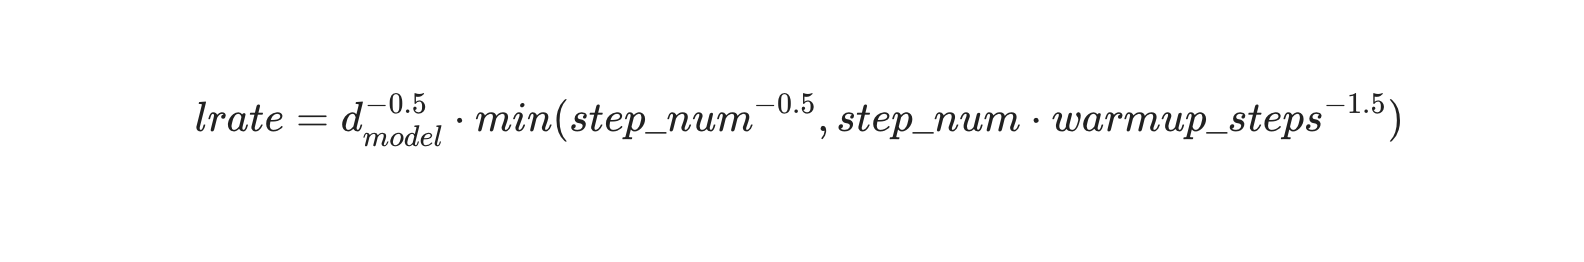

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

$\text{step_num}^{−0.5}$에 비례하는 부분과 $\text{step_num}$에 비례하는 부분 중 작은 쪽을 택하도록 되어 있다.  
그래서 학습 초기에는 learning_rate가 $\text{step_num}$에 비례해서 증가하다가 이후로는 감소하는 것을 확인할 수 있다.

In [ ]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### 모델 컴파일
손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일한다.

In [ ]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### 훈련하기

In [ ]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

## 챗봇 테스트하기
예측(inference) 단계는 기본적으로 다음과 같은 과정을 거친다.

- 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
- 입력 문장을 토크나이징하고, __START_TOKEN__ 과 __END_TOKEN__ 을 추가한다.
- 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
- 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
- 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
- __END_TOKEN__ 이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

위의 과정을 모두 담은 `decoder_inference()` 함수를 만듭니다.

In [ ]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)

임의의 입력 문장에 대해서 `decoder_inference()` 함수를 호출하여 \
챗봇의 대답을 얻는 `sentence_generation()` 함수를 만들어보자.

In [ ]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence

사용해보자!!!!

In [ ]:
sentence_generation('Where have you been?')

In [ ]:
sentence_generation("It's a trap")